In [ ]:
%pip install pandas-datareader==0.10.0


In [3]:
%pip install 'ray[tune]'

ERROR: Invalid requirement: "'ray[tune]'"


In [1]:
# data preprocessing
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
import numpy
import seaborn as sns
import matplotlib.pyplot as plt


# machine learning
import torch
from torch.autograd import Variable
import torch.nn as nn

# hyperparameter tuning
import ray
from ray import tune

### 2. Loading datasets

In [2]:
# loading sentiment scores
sentiment_scores_df = pd.read_csv('data_for_lstm_v3_rifat.csv', index_col=0)
sentiment_scores_df = sentiment_scores_df.iloc[:, 1]
sentiment_scores_df = pd.DataFrame(sentiment_scores_df)
sentiment_scores_df.index = pd.to_datetime(sentiment_scores_df.index)
sentiment_scores_df.head()

,Sentiment Score
date,
2010-06-30,0.848393
2010-07-16,0.944378
2010-09-13,0.988066
2010-09-20,0.882187
2010-10-07,0.916587


In [3]:
start_time_all = datetime.datetime(2019, 1, 1) # 2019-01-01
end_time_train = datetime.datetime(2019, 9, 30) # 2019-09-30
start_time_val = datetime.datetime(2019, 10, 1) # 2019-10-01
end_time_all = datetime.datetime(2019, 12, 31) # 2019-12-31

# loading Tesla, Inc. (TSLA) stock price data from Yahoo Finance
tsla_price_df = pd.read_csv("input_stock_sorted.csv", index_col=0)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

In [4]:
tsla_price_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,21.008667,19.920000,20.406668,20.674667,174879000,20.674667
2019-01-03,20.626667,19.825333,20.466667,20.024000,104478000,20.024000
2019-01-04,21.200001,20.181999,20.400000,21.179333,110911500,21.179333
2019-01-07,22.449333,21.183332,21.448000,22.330667,113268000,22.330667
2019-01-08,22.934000,21.801332,22.797333,22.356667,105127500,22.356667


In [5]:
tsla_price_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-23,28.134001,27.333332,27.452000,27.948000,199794000,27.948000
2019-12-24,28.364668,27.512667,27.890667,28.350000,120820500,28.350000
2019-12-26,28.898666,28.423332,28.527332,28.729334,159508500,28.729334
2019-12-27,29.020666,28.407333,29.000000,28.691999,149185500,28.691999
2019-12-30,28.600000,27.284000,28.586000,27.646667,188796000,27.646667


In [6]:
# adding daily returns to stock price data
tsla_price_df['Return'] = tsla_price_df['Adj Close'].pct_change()
tsla_price_df["Next_Adj_Close"] = tsla_price_df["Adj Close"].shift(-1)
tsla_price_df.at[tsla_price_df.index[-1], "Next_Adj_Close"] = 27.89

In [7]:
tsla_price_df.head()

,High,Low,Open,Close,Volume,Adj Close,Return,Next_Adj_Close
Date,,,,,,,,
2019-01-02,21.008667,19.920000,20.406668,20.674667,174879000,20.674667,NaN,20.024000
2019-01-03,20.626667,19.825333,20.466667,20.024000,104478000,20.024000,-0.031472,21.179333
2019-01-04,21.200001,20.181999,20.400000,21.179333,110911500,21.179333,0.057697,22.330667
2019-01-07,22.449333,21.183332,21.448000,22.330667,113268000,22.330667,0.054361,22.356667
2019-01-08,22.934000,21.801332,22.797333,22.356667,105127500,22.356667,0.001164,22.568666


In [8]:
tsla_price_df.tail()

,High,Low,Open,Close,Volume,Adj Close,Return,Next_Adj_Close
Date,,,,,,,,
2019-12-23,28.134001,27.333332,27.452000,27.948000,199794000,27.948000,0.033605,28.350000
2019-12-24,28.364668,27.512667,27.890667,28.350000,120820500,28.350000,0.014384,28.729334
2019-12-26,28.898666,28.423332,28.527332,28.729334,159508500,28.729334,0.013380,28.691999
2019-12-27,29.020666,28.407333,29.000000,28.691999,149185500,28.691999,-0.001300,27.646667
2019-12-30,28.600000,27.284000,28.586000,27.646667,188796000,27.646667,-0.036433,27.890000


In [9]:
# adding sentiment scores to stock price data
tsla_price_df = pd.merge(tsla_price_df, sentiment_scores_df, left_index=True, right_index=True)
tsla_price_df = tsla_price_df.rename(columns={'sentiment_score_final': 'Sentiment Score'})


In [10]:
tsla_price_df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Return',
       'Next_Adj_Close', 'Sentiment Score'],
      dtype='object')

In [11]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

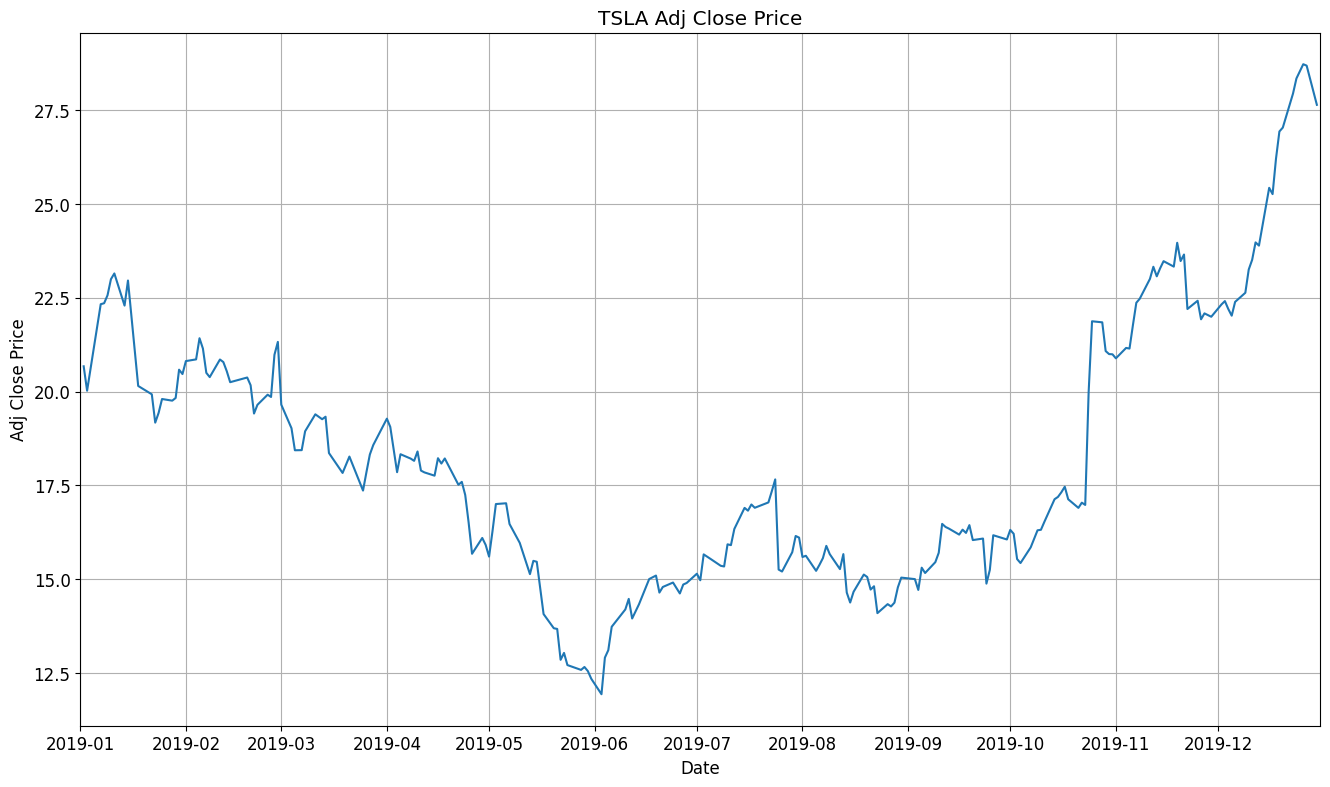

In [12]:
# plotting TSLA Adj Close price from 2019-01-01 to 2019-12-31
plt.plot(tsla_price_df.index, tsla_price_df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Adj Close Price')
plt.show()

In [13]:
# calculating correlation between daily returns and sentiment scores
tsla_price_df['Return'][1:].corr(tsla_price_df['Sentiment Score'][1:])

0.12741443291998478

In [14]:
# calculating correlation between daily returns and adj close prices
tsla_price_df['Sentiment Score'][1:].corr(tsla_price_df['Adj Close'][1:])

0.05578502785912339

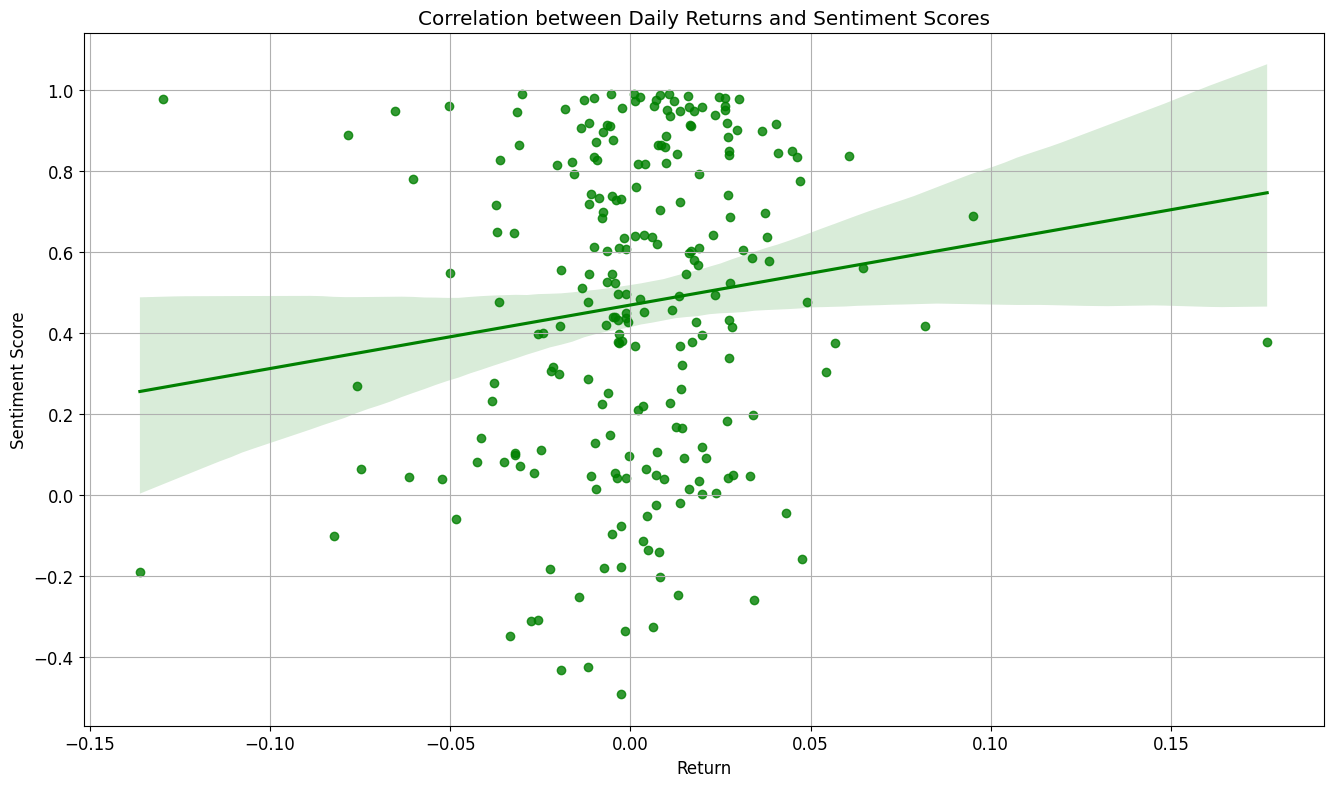

In [15]:
# plotting correlation between daily returns and sentiment scores
sns.regplot(x=tsla_price_df['Return'][1:], y=tsla_price_df['Sentiment Score'][1:], color='g')
plt.title('Correlation between Daily Returns and Sentiment Scores')
plt.show()

In [16]:
# features (High price, Low price, Open price, Close price, Volume, Sentiment Score)
X = tsla_price_df.drop(['Next_Adj_Close',"Adj Close", 'Return'], axis=1)
# response (Adj Close price)
y = tsla_price_df.iloc[:, 7:8]

In [17]:
X.head()

,High,Low,Open,Close,Volume,Sentiment Score
2019-01-02,21.008667,19.920000,20.406668,20.674667,174879000,0.371993
2019-01-03,20.626667,19.825333,20.466667,20.024000,104478000,0.945410
2019-01-07,22.449333,21.183332,21.448000,22.330667,113268000,0.303742
2019-01-08,22.934000,21.801332,22.797333,22.356667,105127500,0.638483
2019-01-09,22.900000,22.098000,22.366667,22.568666,81493500,0.858624


In [18]:
y.head()

,Next_Adj_Close
2019-01-02,20.024000
2019-01-03,21.179333
2019-01-07,22.356667
2019-01-08,22.568666
2019-01-09,22.997999


### 3. Normalizing and converting data

In [19]:
n_split = 175 # where to split training and validation datasets

In [20]:
# normalizing datasets
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y)

# training using Jan - Sep data
# validating trained model using Oct - Dec data
X_train = X_norm[:n_split, :]
y_train = y_norm[:n_split, :]

print('Training Set Shape ', X_train.shape, y_train.shape)

Training Set Shape  (175, 6) (175, 1)


In [21]:
# converting data to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))

X_val_tensors = Variable(torch.Tensor(X_norm))
y_true = numpy.array(y)

# reshaping X dataset
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 
                                                  1, X_train_tensors.shape[1]))
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], 
                                              1, X_val_tensors.shape[1]))

print('Training Set Shape   ', X_train_tensors.shape, y_train_tensors.shape)
print('Validation Set Shape ', X_val_tensors.shape, y_true.shape)

Training Set Shape    torch.Size([175, 1, 6]) torch.Size([175, 1])
Validation Set Shape  torch.Size([233, 1, 6]) (233, 1)


### 4. Building LSTM model

In [22]:
# selecting gpu
device = torch.device('cuda')

In [23]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.is_initialized()

True

In [24]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

### 5. Hyperparameter tuning

In [25]:
# starting ray runtime
ray.init()

2023-06-01 16:31:58,685	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.9.13
Ray version:,2.4.0


In [ ]:
# checking available resources
ray.cluster_resources()

In [27]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

In [28]:
# function for fitting and evaluating model using different hyperparameters
def model_fit_eval(config=None, best_config=None, save_model_state=False):
    if best_config is None:
        hidden_size = config['hidden_size']
        num_layers = config['num_layers']
        learning_rate = config['learning_rate']
        # learning rate controls how much to change model in response to estm error each time model weights are updated
        num_epochs = config['num_epochs']
    else:
        hidden_size = best_config['hidden_size']
        num_layers = best_config['num_layers']
        learning_rate = best_config['learning_rate']
        num_epochs = best_config['num_epochs']

    input_size = 6
    num_classes = 1
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train_tensors.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train_tensors.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        if best_config is not None:
            if epoch % 1000 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    
    # saving model state
    if save_model_state:
        torch.save(model.state_dict(), '4-model-state.pth')

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()
    
    # predicting response from model
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation

    if best_config is None:
        mse = calc_mse(y_true, y_hat)
        tune.report(mse=mse)
    else:
        return y_hat

In [29]:
# using grid search to get best hyperparameters
analysis = tune.run(
    model_fit_eval, 
    config={'hidden_size': tune.grid_search([2, 3, 5]), 
            'learning_rate': tune.grid_search([0.0005, 0.001, 0.002]), 
            'num_epochs': tune.grid_search([2000, 4000, 8000]), 
            'num_layers': tune.grid_search([1, 2, 4])}, 
    resources_per_trial={'cpu': 2, 'gpu': 1}) # leveraging all resources

Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mse,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
model_fit_eval_b5cd9_00000,2023-06-01_16-32-19,True,"0_hidden_size=2,learning_rate=0.0005,num_epochs=2000,num_layers=1",ROzkurt,1,6.13325,127.0.0.1,17448,4.18559,4.18559,4.18559,1685626339,1,b5cd9_00000


2023-06-01 16:53:21,973	INFO tune.py:945 -- Total run time: 1271.88 seconds (1271.80 seconds for the tuning loop).


In [3]:
# visualizing hyperparameter tuning results
%load_ext tensorboard
%tensorboard --logdir ~/ray_results

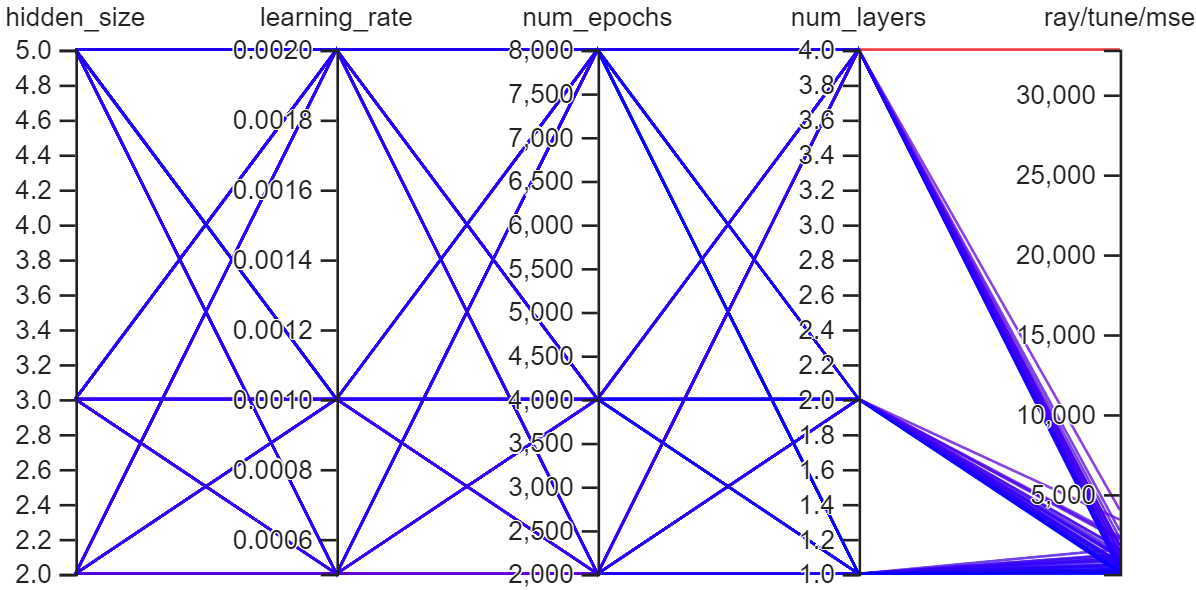

In [32]:
analysis.results


{'b5cd9_00000': {'mse': 6.133251665527159,
  'time_this_iter_s': 4.1855854988098145,
  'done': True,
  'training_iteration': 1,
  'trial_id': 'b5cd9_00000',
  'date': '2023-06-01_16-32-19',
  'timestamp': 1685626339,
  'time_total_s': 4.1855854988098145,
  'pid': 17448,
  'hostname': 'ROzkurt',
  'node_ip': '127.0.0.1',
  'config': {'hidden_size': 2,
   'learning_rate': 0.0005,
   'num_epochs': 2000,
   'num_layers': 1},
  'time_since_restore': 4.1855854988098145,
  'iterations_since_restore': 1,
  'experiment_tag': '0_hidden_size=2,learning_rate=0.0005,num_epochs=2000,num_layers=1'},
 'b5cd9_00001': {'mse': 0.6614325382032972,
  'time_this_iter_s': 4.148630619049072,
  'done': True,
  'training_iteration': 1,
  'trial_id': 'b5cd9_00001',
  'date': '2023-06-01_16-32-27',
  'timestamp': 1685626347,
  'time_total_s': 4.148630619049072,
  'pid': 7288,
  'hostname': 'ROzkurt',
  'node_ip': '127.0.0.1',
  'config': {'hidden_size': 3,
   'learning_rate': 0.0005,
   'num_epochs': 2000,
   'nu

In [33]:
# best hyperparameters
best_trial = analysis.get_best_trial(metric='mse', mode='min', scope='all')
min_mse = best_trial.metric_analysis['mse']['avg']
print(f'Min MSE: {min_mse}')
best_trial_config = best_trial.config
print(f'Best trial config: {best_trial_config}')

Min MSE: 0.368445825962461
Best trial config: {'hidden_size': 5, 'learning_rate': 0.002, 'num_epochs': 2000, 'num_layers': 2}


In [34]:
# training model using best hyperparameters
best_trial_config['num_epochs'] = 10000 # increasing num of epochs
y_hat = model_fit_eval(best_config=best_trial_config, save_model_state=True)

Epoch: 0, Loss: 0.0375
Epoch: 1000, Loss: 0.0008
Epoch: 2000, Loss: 0.0007
Epoch: 3000, Loss: 0.0007
Epoch: 4000, Loss: 0.0007
Epoch: 5000, Loss: 0.0007
Epoch: 6000, Loss: 0.0006
Epoch: 7000, Loss: 0.0006
Epoch: 8000, Loss: 0.0006
Epoch: 9000, Loss: 0.0006
Epoch: 10000, Loss: 0.0006


In [35]:
import numpy as np

In [37]:
y_hat

array([[20.68406  ],
       [20.297466 ],
       [22.585623 ],
       [22.659092 ],
       [22.533014 ],
       [23.094461 ],
       [22.798538 ],
       [22.510595 ],
       [22.60172  ],
       [19.950798 ],
       [19.16143  ],
       [18.96271  ],
       [19.730808 ],
       [20.03151  ],
       [20.053307 ],
       [20.236525 ],
       [20.588371 ],
       [20.219818 ],
       [20.94856  ],
       [21.042702 ],
       [21.445015 ],
       [21.216242 ],
       [20.439768 ],
       [20.67391  ],
       [20.914011 ],
       [21.111313 ],
       [20.382195 ],
       [19.925007 ],
       [20.459442 ],
       [20.301182 ],
       [19.620861 ],
       [19.68459  ],
       [19.400688 ],
       [20.008877 ],
       [20.999166 ],
       [20.30576  ],
       [19.10952  ],
       [18.629528 ],
       [18.349895 ],
       [18.4876   ],
       [18.929632 ],
       [19.269518 ],
       [19.357601 ],
       [18.771479 ],
       [17.928968 ],
       [17.753572 ],
       [17.788189 ],
       [18.43

In [38]:

y_hat_shifted = np.roll(y_hat, 1, axis = 0)
y_hat_shifted


array([[24.482948 ],
       [20.68406  ],
       [20.297466 ],
       [22.585623 ],
       [22.659092 ],
       [22.533014 ],
       [23.094461 ],
       [22.798538 ],
       [22.510595 ],
       [22.60172  ],
       [19.950798 ],
       [19.16143  ],
       [18.96271  ],
       [19.730808 ],
       [20.03151  ],
       [20.053307 ],
       [20.236525 ],
       [20.588371 ],
       [20.219818 ],
       [20.94856  ],
       [21.042702 ],
       [21.445015 ],
       [21.216242 ],
       [20.439768 ],
       [20.67391  ],
       [20.914011 ],
       [21.111313 ],
       [20.382195 ],
       [19.925007 ],
       [20.459442 ],
       [20.301182 ],
       [19.620861 ],
       [19.68459  ],
       [19.400688 ],
       [20.008877 ],
       [20.999166 ],
       [20.30576  ],
       [19.10952  ],
       [18.629528 ],
       [18.349895 ],
       [18.4876   ],
       [18.929632 ],
       [19.269518 ],
       [19.357601 ],
       [18.771479 ],
       [17.928968 ],
       [17.753572 ],
       [17.78

In [39]:
# shutting down ray runtime
ray.shutdown()

### 6. Results

In [40]:
# function for plotting actual and predicted Adj Close price
def plt_graph(start_time, end_time, period, val_line=False):
    # plotting actual Adj Close price
    plt.plot(tsla_price_df.index, y_true, label='Actual Price')
    # plotting predicted Adj Close price
    plt.plot(tsla_price_df.index, y_hat_shifted, label='Pred Price')
    if val_line:
        plt.axvline(x=start_time_val, c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

#### All period

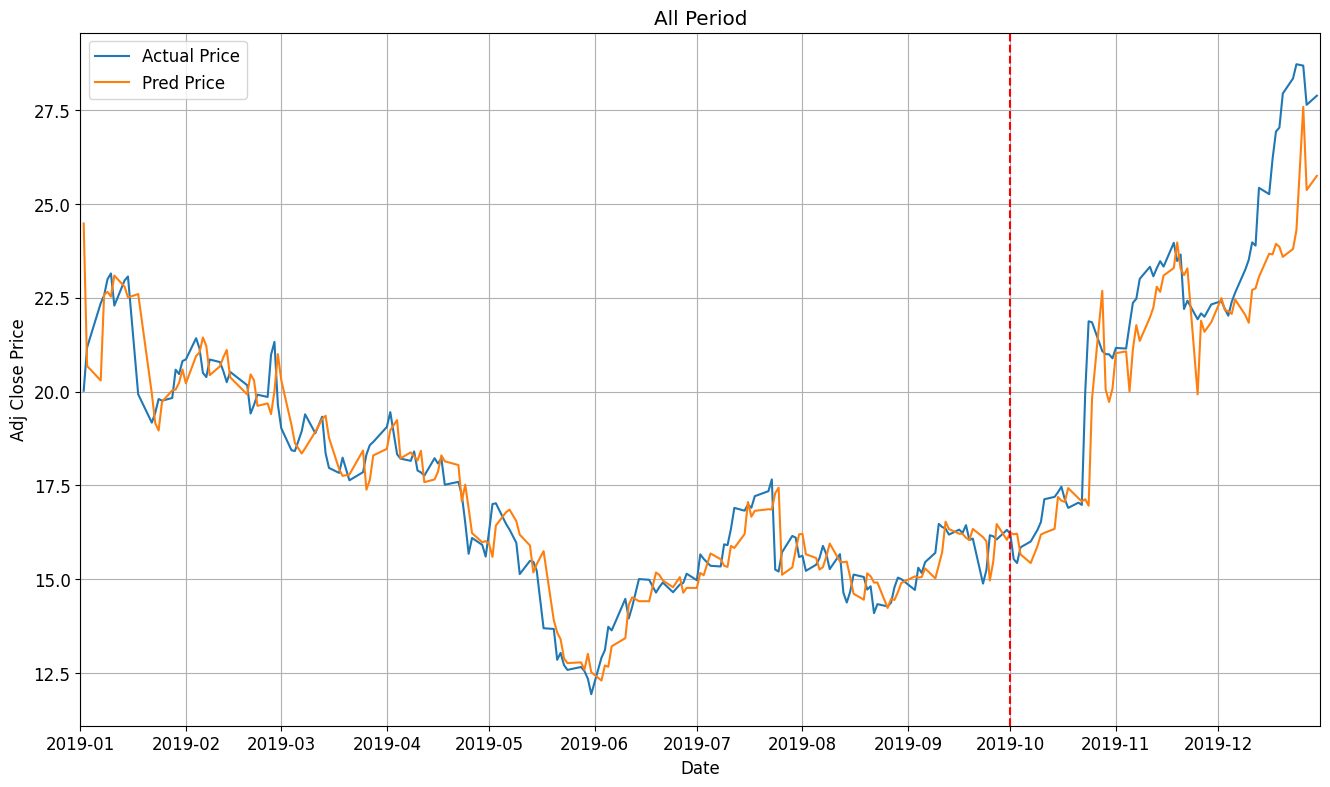

In [41]:
# plotting all period
period = 'All'
plt_graph(start_time_all, end_time_all, period, True)

In [46]:
mse = calc_mse(y_true, y_hat_shifted)
print(f'MSE ({period}): {mse}')

MSE (Validation): 1.1863366886717979


#### Training period

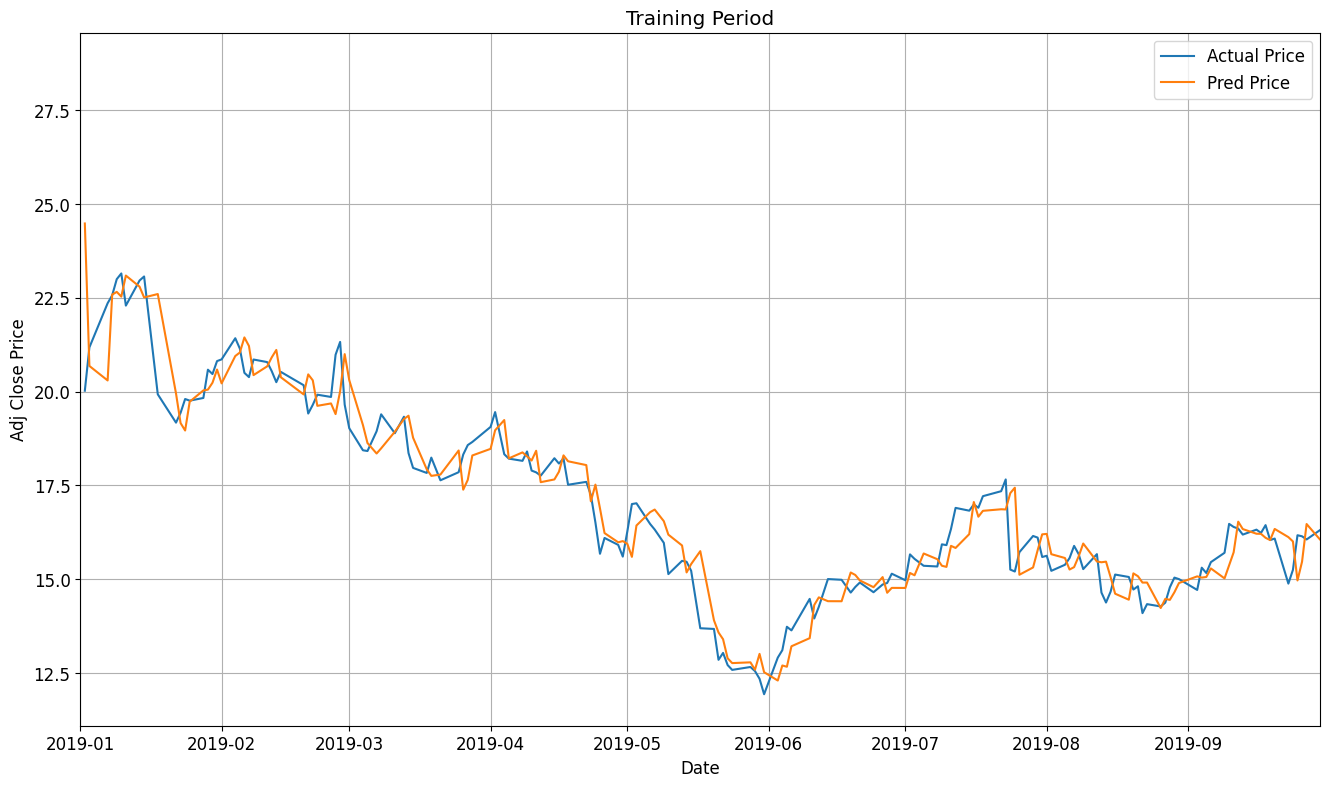

In [48]:
# plotting training period
period = 'Training'
plt_graph(start_time_all, end_time_train, period)

In [49]:
mse = calc_mse(y_true[:n_split], y_hat_shifted[:n_split])
print(f'MSE ({period}): {mse}')

MSE (Training): 0.5837551690630792


#### Validation period

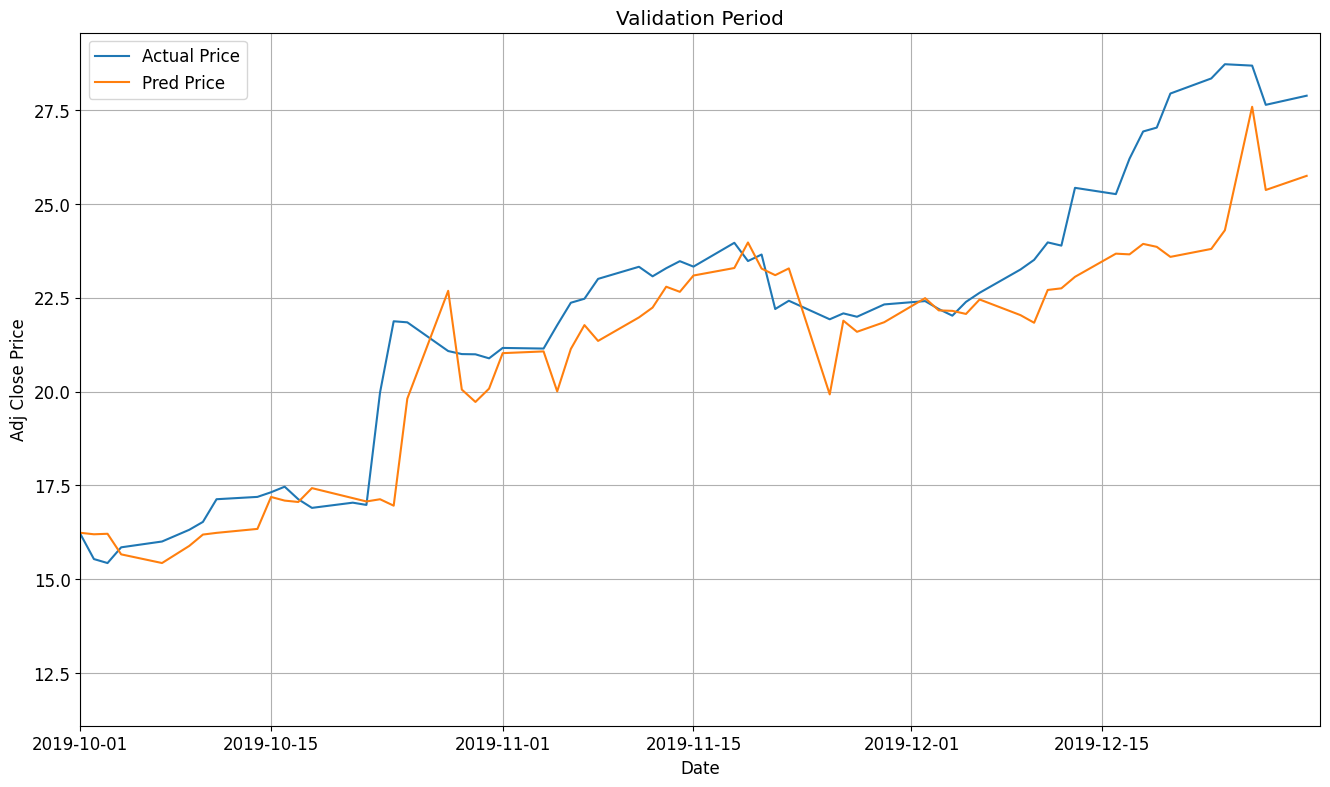

In [50]:
# plotting validation period
period = 'Validation'
plt_graph(start_time_val, end_time_all, period)

In [51]:
mse = calc_mse(y_true[n_split:], y_hat_shifted[n_split:])
print(f'MSE ({period}): {mse}')

MSE (Validation): 2.266639753118555


In [117]:
validation_pred = y_hat_shifted[n_split:]
validation_true = y_true[n_split:]

In [118]:
df_val_pred = pd.DataFrame(validation_pred, columns = ['Predicted Price'])
df_val_true = pd.DataFrame(validation_true, columns = ['Actual Price'])

In [119]:
df_val_pred['Pred_Return'] = df_val_pred["Predicted Price"].pct_change()
df_val_pred.head()

,Predicted Price,Pred_Return
0,15.429372,NaN
1,15.886081,0.029600
2,16.188181,0.019017
3,16.233702,0.002812
4,16.339338,0.006507


In [120]:
df_val_true['Actual Return'] = df_val_true['Actual Price'].pct_change()
df_val_true.head()

,Actual Price,Actual Return
0,16.003332,NaN
1,16.316000,0.019538
2,16.525999,0.012871
3,17.130667,0.036589
4,17.192667,0.003619


In [152]:
tsla_price_df_dates = tsla_price_df.reset_index()

In [153]:
tsla_price_df_dates.head()

,index,High,Low,Open,Close,Volume,Adj Close,Return,Next_Adj_Close,Sentiment Score
0,2019-01-02,21.008667,19.920000,20.406668,20.674667,174879000,20.674667,NaN,20.024000,0.371993
1,2019-01-03,20.626667,19.825333,20.466667,20.024000,104478000,20.024000,-0.031472,21.179333,0.945410
2,2019-01-07,22.449333,21.183332,21.448000,22.330667,113268000,22.330667,0.054361,22.356667,0.303742
3,2019-01-08,22.934000,21.801332,22.797333,22.356667,105127500,22.356667,0.001164,22.568666,0.638483
4,2019-01-09,22.900000,22.098000,22.366667,22.568666,81493500,22.568666,0.009483,22.997999,0.858624


In [155]:
df_val_pred_true_dates = pd.merge(df_val_pred, df_val_true, left_index=True, right_index=True)
df_val_pred_true_dates = pd.merge(df_val_pred_true_dates, tsla_price_df_dates, left_on="Actual Price", right_on="Adj Close")
df_val_pred_true_dates.tail()

,Predicted Price,Pred_Return,Actual Price,Actual Return,index,High,Low,Open,Close,Volume,Adj Close,Return,Next_Adj_Close,Sentiment Score
53,23.592442,-0.011216,27.948000,0.033605,2019-12-23,28.134001,27.333332,27.452000,27.948000,199794000,27.948000,0.033605,28.350000,0.586073
54,23.804380,0.008983,28.350000,0.014384,2019-12-24,28.364668,27.512667,27.890667,28.350000,120820500,28.350000,0.014384,28.729334,0.164646
55,24.302858,0.020941,28.729334,0.013380,2019-12-26,28.898666,28.423332,28.527332,28.729334,159508500,28.729334,0.013380,28.691999,0.491958
56,27.594650,0.135449,28.691999,-0.001300,2019-12-27,29.020666,28.407333,29.000000,28.691999,149185500,28.691999,-0.001300,27.646667,0.495119
57,25.376038,-0.080400,27.646667,-0.036433,2019-12-30,28.600000,27.284000,28.586000,27.646667,188796000,27.646667,-0.036433,27.890000,0.476559


<Axes: title={'center': 'Predicted vs Actual Returns'}, xlabel='Days Between Oct-Dec 2019', ylabel='Returns (%)'>

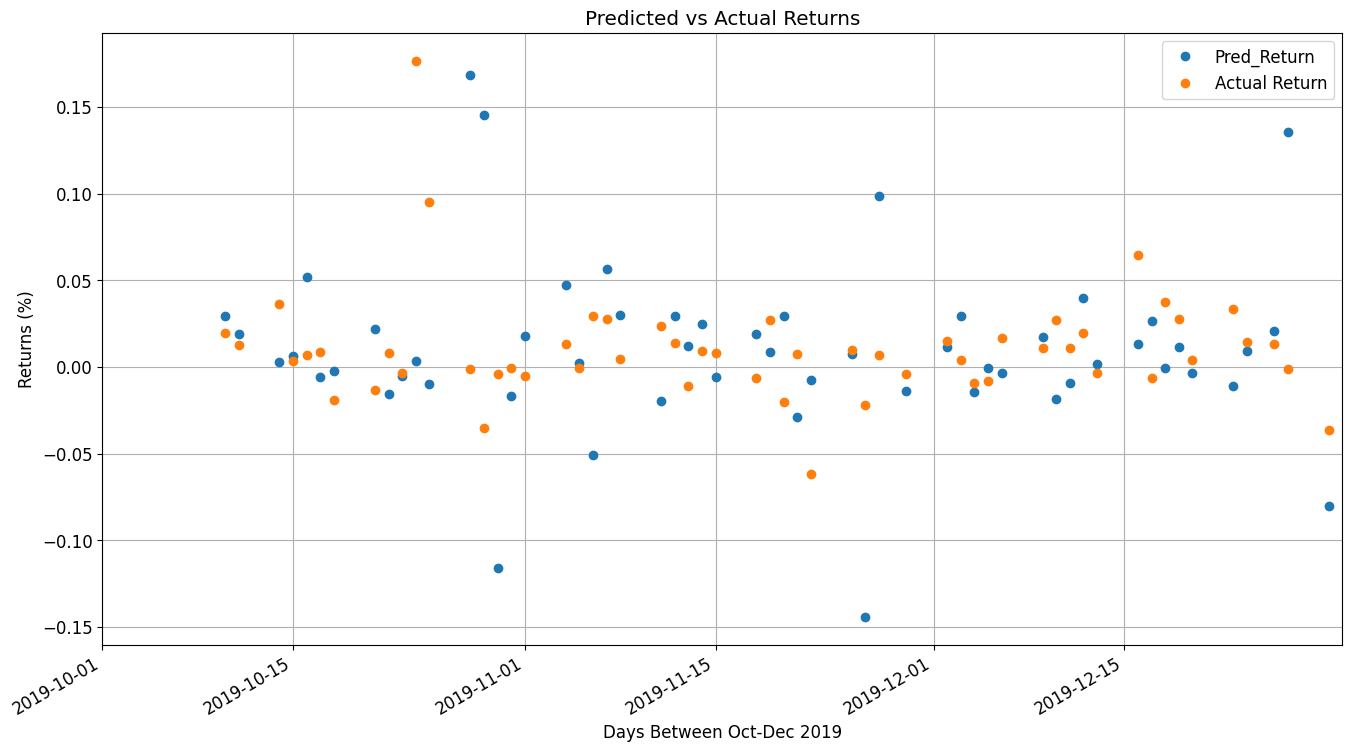

In [157]:
df_val_pred_true_dates.plot(x="index", y= ['Pred_Return', 'Actual Return'], figsize=(16,9), grid=True, title='Predicted vs Actual Returns', marker='o', linestyle=" ", xlabel='Days Between Oct-Dec 2019', ylabel='Returns (%)', xlim=(start_time_val,end_time_all))

In [139]:
df_val_pred_true_dates['Actual Return'][1:].corr(df_val_pred_true_dates['Pred_Return'][1:])

-0.012118045444172635

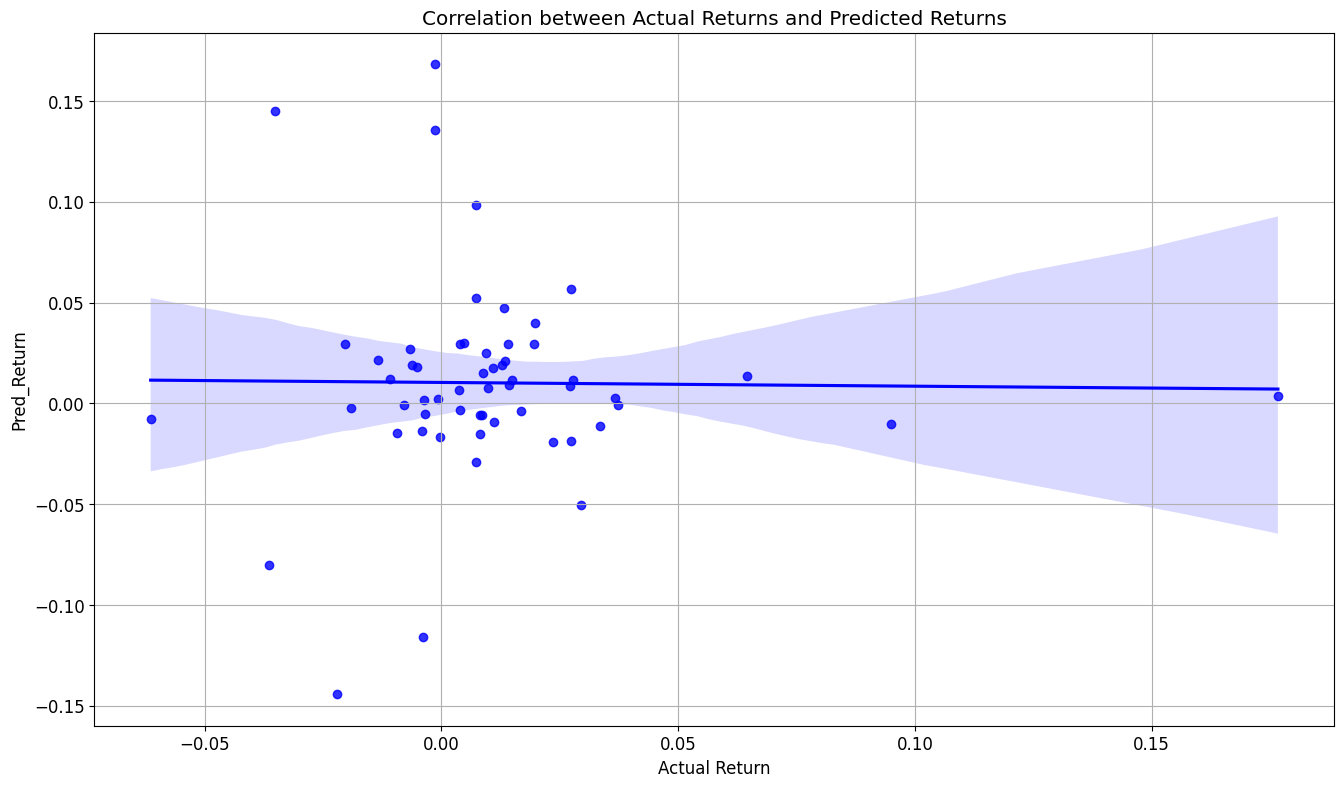

In [124]:
sns.regplot(x=df_val_pred_true_dates['Actual Return'][1:], y=df_val_pred_true_dates['Pred_Return'][1:], color='b')
plt.title('Correlation between Actual Returns and Predicted Returns')
plt.show()